# Gift Recommendation System

This Jupyter Notebook uses OpenAI's API to recommend personalized gifts based on user input.

### Steps to Run:
1. Install dependencies:
   ```sh
   pip install langchain langchain_openai langgraph python-dotenv pandas
   ```
2. Create a `.env` file with your OpenAI API key:
   ```
   OPENAI_API_KEY=your-api-key-here
   ```
3. Run all the cells to generate personalized gift recommendations.


In [3]:
import operator
import re
from typing import TypedDict, Annotated, Optional, List

from langchain_core.messages import SystemMessage, HumanMessage
from langchain_openai import ChatOpenAI
from langgraph.graph import StateGraph, START, END

SAMPLE_PRODUCTS = [
    {
        "title": "Personalized Coffee Mug",
        "price": "$15",
        "image_url": "http://example.com/coffeemug.jpg",
        "view_more_url": "http://example.com/coffeemug",
    },
    {
        "title": "Scented Candle Set",
        "price": "$20",
        "image_url": "http://example.com/scentedcandles.jpg",
        "view_more_url": "http://example.com/scentedcandles",
    },
    {
        "title": "Warm Winter Scarf",
        "price": "$40",
        "image_url": "http://example.com/winterscarf.jpg",
        "view_more_url": "http://example.com/winterscarf",
    },
    {
        "title": "Box of Gourmet Chocolates",
        "price": "$35",
        "image_url": "http://example.com/gourmetchocolates.jpg",
        "view_more_url": "http://example.com/gourmetchocolates",
    },
    {
        "title": "Indoor Herb Garden Kit",
        "price": "$45",
        "image_url": "http://example.com/herbgarden.jpg",
        "view_more_url": "http://example.com/herbgarden",
    },
    {
        "title": "Leather Wallet",
        "price": "$60",
        "image_url": "http://example.com/leatherwallet.jpg",
        "view_more_url": "http://example.com/leatherwallet",
    },
    {
        "title": "Cozy Throw Blanket",
        "price": "$35",
        "image_url": "http://example.com/cozyblanket.jpg",
        "view_more_url": "http://example.com/cozyblanket",
    },
    {
        "title": "Flowers for Mother's Day",
        "price": "$25",
        "image_url": "http://example.com/mothersdayflowers.jpg",
        "view_more_url": "http://example.com/mothersdayflowers",
    },
    {
        "title": "Luxury Handbag",
        "price": "$150",
        "image_url": "http://example.com/luxuryhandbag.jpg",
        "view_more_url": "http://example.com/luxuryhandbag",
    },
    {
        "title": "Chocolate Cake",
        "price": "$30",
        "image_url": "http://example.com/chocolatecake.jpg",
        "view_more_url": "http://example.com/chocolatecake",
    },
]


llm = ChatOpenAI(model="gpt-4o", temperature=0)


class State(TypedDict):
    name: Optional[str]
    gift_subject: Optional[str]
    gift_object: Optional[str]
    price_range: Optional[str]
    summary: Optional[str]
    product_list: Optional[List[dict]]
    conversation: Annotated[list, operator.add]


system_message = SystemMessage(
    content="""\
You are a creative, friendly gift recommendation assistant. 
We (the code) handle the conversation flow. You:
- only produce short lines if asked
- or validate user input if asked
- or finalize product recommendations if asked
"""
)

validation_system_message = SystemMessage(
    content="""\
You are a validation assistant. 
We do not allow vulgarity, profanity, or hateful language in user input.
If the user input is profane or hateful, respond with "NO" on line 1 and 
short explanation on line 2 ("We do not allow profanity."). 
Otherwise, if the user input is valid, respond "YES". If uncertain, respond "UNKNOWN".

Your output must have exactly two lines:

Line 1: "YES" or "NO" or "UNKNOWN"
Line 2: short explanation (1 sentence).
No extra disclaimers.
"""
)


def validate_input_llm(question: str, user_input: str) -> bool:
    """
    LLM-based validation.
    If LLM says "YES" => valid,
    If "NO"/"UNKNOWN" => invalid => re-ask user
    """
    prompt = f"""
Question: {question}
User Input: {user_input}

Is this input valid for that question, and free from profanity?
Line 1 => "YES" or "NO" or "UNKNOWN"
Line 2 => short explanation
"""
    response = llm.invoke([validation_system_message, HumanMessage(content=prompt)])
    lines = [l.strip() for l in response.content.splitlines() if l.strip()]
    if not lines:
        return False
    verdict = lines[0].upper()
    return verdict == "YES"


def interpret_confirmation_with_llm(user_input: str) -> Optional[bool]:
    """
    Asks the LLM if the user's response means yes or no.
    Returns True => yes, False => no, None => unknown.
    We also keep the same "no profanity" rule here if you want.
    """
    prompt = f"""
We do not allow profanity in the user's summary confirmation.
Does this user input confirm the summary (yes) or deny it (no)?

User input: {user_input}

Answer in exactly two lines:
Line 1 => "YES", "NO", or "UNKNOWN"
Line 2 => short explanation
"""
    response = llm.invoke([validation_system_message, HumanMessage(content=prompt)])
    lines = [l.strip() for l in response.content.splitlines() if l.strip()]
    if not lines:
        return None
    verdict = lines[0].upper()
    if verdict == "YES":
        return True
    elif verdict == "NO":
        return False
    else:
        return None


def get_personalized_line(task: str) -> str:
    """
    Let the LLM generate a single short line to ask the user for `task`.
    """
    prompt = f"""
Task: {task}
Generate a single short line to ask the user for {task} in a friendly, creative way.
Keep it under 20 words, no disclaimers, just the line.
Use emojis if you like.
"""
    response = llm.invoke([system_message, HumanMessage(content=prompt)])
    return response.content.strip().replace("\n", " ")


def gather_information(state: State) -> State:
    """
    Gather name, gift_subject, gift_object, price_range
    all validated by LLM for no profanity.
    """

    def ask_and_validate(question_task: str, field_name: str):
        while state.get(field_name) is None:
            question_text = get_personalized_line(question_task)
            print(question_text)

            user_input = input("> ").strip()
            if not user_input:
                print("Please provide an answer.\n")
                continue

            if question_task == "ask_for_price_range":
                if not re.search(r"\d", user_input):
                    print("That doesn't seem to contain numbers. Try again.\n")
                    continue

            is_valid = validate_input_llm(question_task, user_input)
            if is_valid:
                state[field_name] = user_input
            else:
                print(
                    "That doesn't seem right (maybe it's profane or invalid). Let's try again.\n"
                )

    if state["name"] is None:
        ask_and_validate("ask_for_name", "name")

    if state["gift_subject"] is None:
        ask_and_validate("ask_for_recipient", "gift_subject")

    if state["gift_object"] is None:
        ask_and_validate("ask_for_gift_type", "gift_object")

    if state["price_range"] is None:
        ask_and_validate("ask_for_price_range", "price_range")

    return state


def provide_summary(state: State) -> State:
    if not (
        state["name"]
        and state["gift_subject"]
        and state["gift_object"]
        and state["price_range"]
    ):
        return state

    prompt = f"""
The user provided:
Name: {state["name"]}
Gift for: {state["gift_subject"]}
Gift type: {state["gift_object"]}
Price range: {state["price_range"]}

Write 1-2 lines summarizing these in a playful tone.
End with: "Does that look correct? (yes/no)"
No profanity, no disclaimers.
"""
    response = llm.invoke([system_message, HumanMessage(content=prompt)])
    summary = response.content.strip()
    print(summary)

    user_input = input("> ").strip()
    interpretation = interpret_confirmation_with_llm(user_input)

    if interpretation is True:
        state["summary"] = summary
    else:
        print("Alright, let's gather details again.\n")
        state["name"] = None
        state["gift_subject"] = None
        state["gift_object"] = None
        state["price_range"] = None
        state["summary"] = None
        state["product_list"] = None

    return state


def recommend_products(state: State) -> State:
    if not state.get("summary"):
        return state

    gift_object = (state["gift_object"] or "").lower()
    user_words = gift_object.split()

    relevant = []
    for product in SAMPLE_PRODUCTS:
        title_words = product["title"].lower().split()
        if set(user_words).intersection(set(title_words)):
            relevant.append(product)

    if len(relevant) < 3:
        for product in SAMPLE_PRODUCTS:
            if product not in relevant:
                relevant.append(product)
            if len(relevant) >= 3:
                break

    final_candidates = relevant[:3]

    rec_prompt = f"""
We have these 3 candidate products:
{final_candidates}

User info:
- Name: {state["name"]}
- Gift for: {state["gift_subject"]}
- Gift type: {state["gift_object"]}
- Price range: {state["price_range"]}

Return exactly 3 products in JSON array format:
[
  {{
    "title": "...",
    "price": "...",
    "image_url": "...",
    "view_more_url": "..."
  }},
  ...
]
No profanity, no disclaimers, no text outside JSON.
"""
    response = llm.invoke([system_message, HumanMessage(content=rec_prompt)])
    raw_json = response.content.strip()
    print("\nLLM's recommended products (raw):\n", raw_json)

    # Parse JSON or fallback
    try:
        state["product_list"] = eval(raw_json)
    except:
        state["product_list"] = final_candidates

    print("\nYour personalized gift recommendations:")
    for p in state["product_list"]:
        print(f"- {p.get('title', 'Untitled')} at {p.get('price', '???')}")
    return state


builder = StateGraph(State)
builder.add_node("gather_information", gather_information)
builder.add_node("provide_summary", provide_summary)
builder.add_node("recommend_products", recommend_products)

builder.add_edge(START, "gather_information")
builder.add_edge("gather_information", "provide_summary")
builder.add_edge("provide_summary", "recommend_products")
builder.add_edge("recommend_products", END)

builder.add_conditional_edges(
    "provide_summary",
    lambda s: "gather_information" if not s.get("summary") else "recommend_products",
)
builder.add_conditional_edges(
    "recommend_products",
    lambda s: "provide_summary" if not s.get("summary") else END,
)

graph = builder.compile()

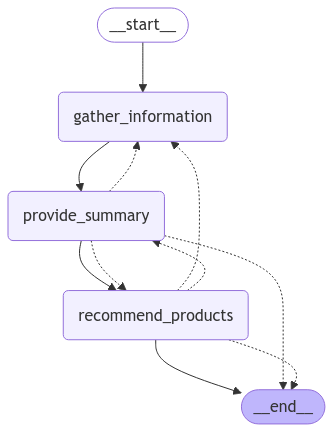

In [4]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))